# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [2]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
sns.set_theme(context='notebook', style='darkgrid', palette='bright', font='serif', color_codes=True, 
              rc={'figure.figsize':(10,8), 'axes.titlesize':18,'axes.labelsize':16, 'font.family': 'Verdana', 'lines.linewidth': 2 })
import matplotlib.pyplot as plt # для построения графиков


Прочитаем исходные данные:

In [3]:
data = pd.read_csv('data/unconv.csv')
print(data.shape)
data.head()

(200, 8)


,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

***
Сразу же удалим излишний призак-индексатор `Well`, выведем на экран информацию о данных и основные числовые описательные статистики.

In [4]:
data.drop('Well', axis=1, inplace=True)
data.info()
print("--"*42)
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Por      200 non-null    float64
 1   Perm     200 non-null    float64
 2   AI       200 non-null    float64
 3   Brittle  200 non-null    float64
 4   TOC      200 non-null    float64
 5   VR       200 non-null    float64
 6   Prod     200 non-null    float64
dtypes: float64(7)
memory usage: 11.1 KB
------------------------------------------------------------------------------------


,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


>Все признаки числовые и представлены в формате `float64`, который довольно ресурсоемкий, но в рамках 200 сэмплов не играет роли; значений NaN в данных нет, аномалий также на первый взгляд не наблюдается

Посмотрим на распределения всех признаков и на попарные взаимосвязи.

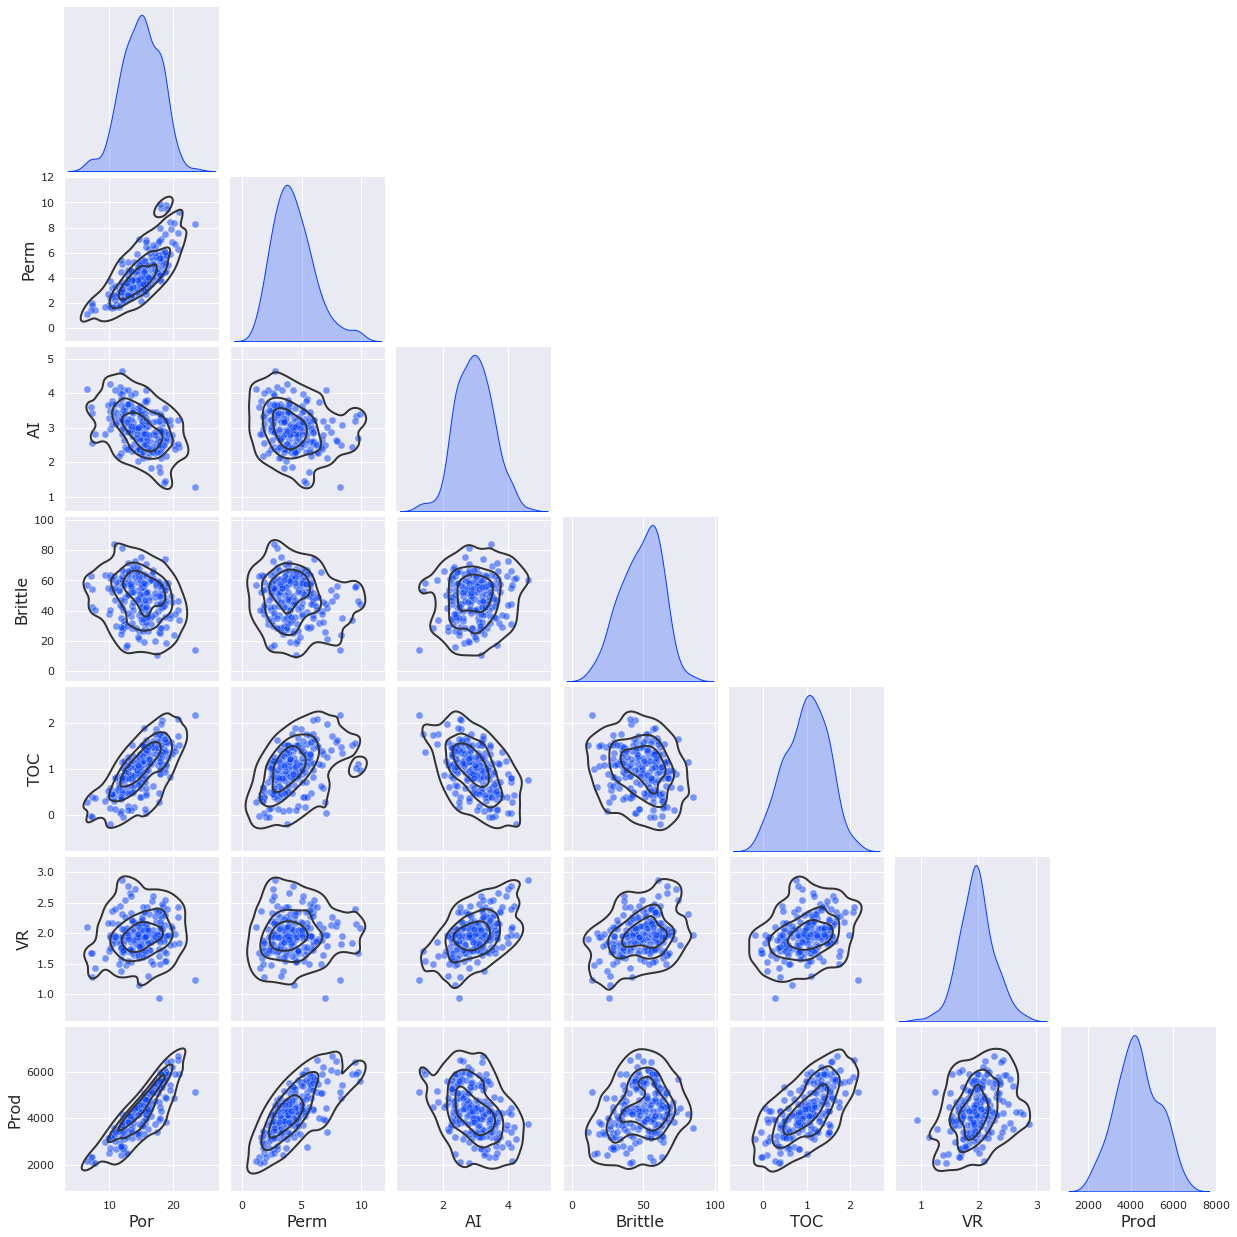

In [5]:
sns.pairplot(data=data, diag_kind='kde', corner=True, plot_kws=dict(s=50, alpha=0.5)).map_lower(sns.kdeplot, levels=4, color=".2");

> Все признаки распределены симметрично, почти гауссово. Если смотреть на взаимосвязи и на форму контура от KDE-plot наиболее плотного участка графика явно бросается в глаза прямая линейная зависимость между слудующими парами признаков: `Perm - Por`; `Toc - Por`; **`Prod - Por`** (наиболее явная); `Prod - Perm`; `Prod - TOC`. Также можно отметить уже не такую сильную, но заметную обратную пропорциональность между признаками: `AI - Por`; `AI - TOC`.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Correlation matrix rank: 7
Correlation matrix determinant: 0.0007477684988022858


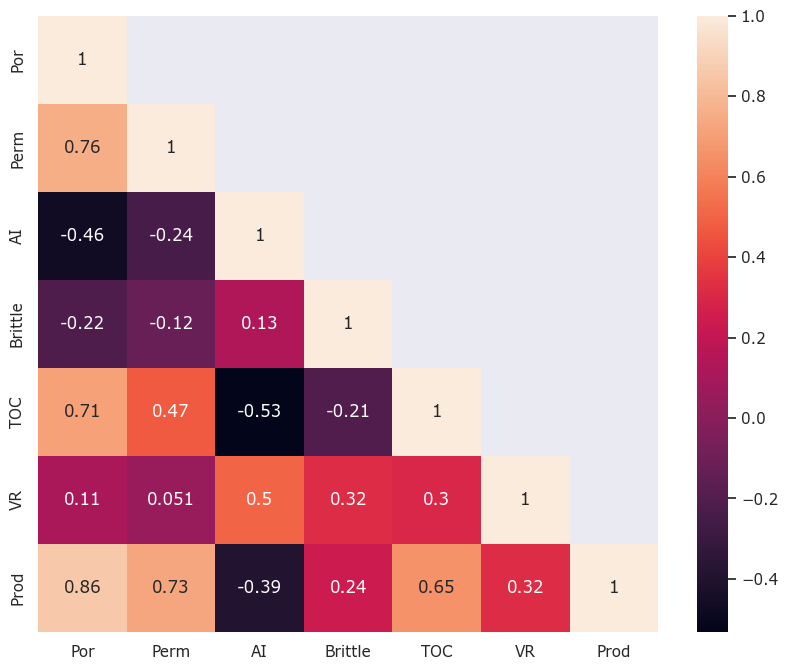

In [6]:
plt.figure(figsize=(10,8))
corr_mtx = data.corr() #np.corrcoef(data, rowvar=False)
mask = np.triu(corr_mtx, k=1)
sns.heatmap(corr_mtx, annot=True, fmt='.2g', mask=mask)
print(f"Correlation matrix rank: {np.linalg.matrix_rank(corr_mtx)}")
print(f"Correlation matrix determinant: {np.linalg.det(corr_mtx)}")

> По матрице выборочных корреляций можем сказать, что факторы: `Por`, `Perm` и `Toc` наиболее сильно линейно связаны с целевой переменной `Prod`. Исходя из того, что определитель корр. матрицы очень близок к нулю, делаем вывод, что данные **плохо обусловлены**. Так как ранг равен размерности матрицы - чистой коллинеарности между векторами признаков нет, признаки `Perm` и `Por` коррелируют довольно сильно (0.76), но в целом, исходя из матрицы корреляций можно сказать, что явной мультиколлинеарности в данных не наблюдается. Классическое аналитическое решение МНК для задачи регрессии в данном случае **неприменимо** вследствие близости к вырожденности матрицы $(A^TA)$

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [7]:
X = np.column_stack((np.ones(200), data.drop('Prod', axis=1)))
y = data['Prod']
# вектор весов линейной регресии по МНК
w = np.round(np.linalg.inv(X.T @ X) @ X.T @ y)

In [8]:
# Выведем полученные веса для соответствующих факторов
indexes = ['Intersept'] + list(data.drop('Prod', axis=1).columns)
features_coeffs = pd.Series(w, index=indexes)
features_coeffs

Intersept   -1230.0
Por           230.0
Perm          116.0
AI           -364.0
Brittle        25.0
TOC           -77.0
VR            783.0
dtype: float64

> Согласно модели, построенной на сырых данных, можно счесть коэффициент хрупкости скважины - `Brittle` малоинформативным признаком для предсказания продуктивности скважины. Коэффициент отражения витринита - `VR`, согласно данной модели вносит наибольшой вклад (не считая свободного члена): с увеличением VR на 1% доходность скважины растет в среднем на 783 млн. кубических футов в сутки. С акустическим импедансом - `AI` обратная ситуация: при его увелечении на 1 условную единицу, доходность скважины падает примерно на 364 млн. кубических футов в сутки.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [9]:
from sklearn.metrics import mean_absolute_error, r2_score
new_sample = pd.Series({
    'Intercept': 1,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 })
new_target_true = 4748.315094
new_target_pred = new_sample @ w
print(f"AE for new sample: {abs(new_target_true - new_target_pred):.2f}")
print('--'*16)
X_preds = X @ w
print(f"MAE for train data: {mean_absolute_error(X_preds, y):.2f}")
print(f"Coefficient of determination for train data: {r2_score(X_preds, y):.2f}")

AE for new sample: 31.26
--------------------------------
MAE for train data: 154.27
Coefficient of determination for train data: 0.96


> По метрикам MAE и $R^2$ score, расчитанных на обучающем наборе, можем судить, что модель в среднем ошибается при прогнозе на 154 млн. кубических фута добытого газа в сутки. Также наша модель смогла объяснить 96% дисперсии целевой переменной.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [10]:
print("LR Weights")
display(features_coeffs[1:])
print('--'*16)
print("Corr. with target")
corr_mtx['Prod'][:-1]

LR Weights


Por        230.0
Perm       116.0
AI        -364.0
Brittle     25.0
TOC        -77.0
VR         783.0
dtype: float64

--------------------------------
Corr. with target


Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Name: Prod, dtype: float64

> Наблюдается противоречие в отношении целевой переменной с фактором `TOC`: значение корреляции между ними говорит о наличии некой прямой зависимости, однако соответствующее этому признаку весовой коэффицент, полученный МНК показывает наоборот, отрицательный вклад данного фактора на -77 млн. кубических футов газа в сутки при увеличении `TOC ` на 1 усл. единицу. Также факторы, сильно скоррелированные с целевой переменной, а именно `Por` и `Perm` имеют довольно низкий вклад в полученной модели  в сравнении с `VR`, линейная связь которого с целевой переменной порядком ниже.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [11]:
# Оставим признак `Por` 
cols_to_exclude = ['TOC', 'Perm']
X_exc = np.column_stack((np.ones(200), data.drop(cols_to_exclude + ['Prod'], axis=1)))
w_exc = np.round(np.linalg.inv(X_exc.T @ X_exc) @ X_exc.T @ y)

# Выведем полученные веса для соответствующих факторов
indexes = ['Intersept'] + list(data.drop(cols_to_exclude + ['Prod'], axis=1).columns)
features_coeffs = pd.Series(w_exc, index=indexes)
print("New LR weights on excluded data: ")
print(features_coeffs)
print("--"*16)

X_exc_preds = X_exc @ w_exc
print(f"MAE for exc train data: {mean_absolute_error(X_exc_preds, y):.2f}")
print(f"Coefficient of determination for exc train data: {r2_score(X_exc_preds, y):.2f}")


New LR weights on excluded data: 
Intersept   -1835.0
Por           293.0
AI           -200.0
Brittle        28.0
VR            517.0
dtype: float64
--------------------------------
MAE for exc train data: 171.87
Coefficient of determination for exc train data: 0.94


> Фактор `Por` в новой модели вносит более сильный вклад прогноз, чем в прошлой: с увеличением пористости на 1% объем добычи газа в среднем растет на 293 млн. кубических футов, `VR` всё также сильнее всего влияет на прогноз, но слабее, нежели чем в первой модели. Признак хрупкости скважины - `Brittle` также остался малоинформативным: c каждым процентом его роста целевая переменная увеличивается на 25 млн. кубических футов. Противоречий между весовыми коэффицентами факторов и значениям их корреляции с целевой переменной после удаления сильно скоррелированных признаков нет.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [12]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(X_exc,y)
lr_preds = lr_model.predict(X_exc)

print(f"MAE for exc train data: {mean_absolute_error(lr_preds, y):.2f}")
print(f"Coefficient of determination for exc train data: {r2_score(lr_preds, y):.2f}")

MAE for exc train data: 171.43
Coefficient of determination for exc train data: 0.94


> Разница между метриками, полученными с помощью модели, построенной вручную и модели, реализованной в sklearn минимальна(0.4 по MAE). Возможно эта разница обусловена использованием метода SVD в sklearn.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [13]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [82]:
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
mape = make_scorer(mean_absolute_percentage_error)

X = data.drop(cols_to_exclude + ['Prod'], axis=1)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_std_poly = poly.fit_transform(X_std)
print(f"Всего факторов без свободного члена: {X_std_poly.shape[1]}")

lr = LinearRegression()
cv_results = cross_validate(lr, X_std_poly, y, scoring=mape, cv=5, return_train_score=True)
print(f'MAPE на тренировочных фолдах: {cv_results["train_score"].mean()* 100:.2f} %')
print(f'MAPE на тестовых фолдах: {cv_results["test_score"].mean()* 100:.2f} %')


Всего факторов без свободного члена: 34
MAPE на тренировочных фолдах: 1.77 %
MAPE на тестовых фолдах: 2.68 %


> В целом, процент ошибки как на тренировочных, так и на тестовых фолдах довольно низок, однако можно попробовать достичь более низкого разброса модели и улучшить метрику на тестовых фолдах.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [91]:
grid_lasso = GridSearchCV(Lasso(max_iter=10000, random_state=42), param_grid={'alpha': np.arange(0.01, 5.05, 0.05)}, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_lasso.fit(X_std_poly,y)
print(f"Подобранное значение alpha: {grid_lasso.best_params_}")
coefs = grid_lasso.best_estimator_.coef_
print(f"Количество обнуленных коэфицентов: {len(coefs) - np.count_nonzero(coefs)}")


cv_results = cross_validate(grid_lasso.best_estimator_, X_std_poly, y, scoring=mape, cv=5, return_train_score=True)
print(f'MAPE Lasso на тренировочных фолдах: {cv_results["train_score"].mean()* 100:.2f} %')
print(f'MAPE Lasso на тестовых фолдах: {cv_results["test_score"].mean()* 100:.2f} %')


Подобранное значение alpha: {'alpha': 4.61}
Количество обнуленных коэфицентов: 15
MAPE Lasso на тренировочных фолдах: 1.82 %
MAPE Lasso на тестовых фолдах: 2.28 %


> После применения L1 регуляризации, смещение модели, ожидаемо выросло о чем можно судить по MAPE на тренир. фолдах, 
> однако удалось ощутимо снизить разброс в сравнении с предыдущим результатом. Видим также, что в процессе регуляризации 15 из 34 факторов сочлись либо малозначимыми либо высококоррелированными и коэффиценты при них обнулились.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [113]:
grid_ridge = GridSearchCV(Ridge(max_iter=10000,random_state=42), param_grid={'alpha': np.arange(0.01, 5.05, 0.05)}, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_ridge.fit(X_std_poly,y)
print(f"Подобранное значение alpha: {grid_ridge.best_params_}")

cv_results = cross_validate(grid_ridge.best_estimator_, X_std_poly, y, scoring=mape, cv=5, return_train_score=True)
print(f'MAPE Ridge на тренировочных фолдах: {cv_results["train_score"].mean()* 100:.2f} %')
print(f'MAPE Ridge на тестовых фолдах: {cv_results["test_score"].mean()* 100:.2f} %')

Подобранное значение alpha: {'alpha': 0.16000000000000003}
MAPE Ridge на тренировочных фолдах: 1.77 %
MAPE Ridge на тестовых фолдах: 2.67 %


> В нашем случае L2 регуляизация отработала хуже, чем L1 и почти идентично со стандартной LinearRegression.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [106]:
grid_elnet = GridSearchCV(ElasticNet(max_iter=10000,random_state=42), param_grid={'alpha': np.arange(0.01, 5.05, 0.05), 'l1_ratio': np.linspace(0.01, 1., 30)}, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_elnet.fit(X_std_poly,y)
print(f"Подобранное значение alpha: {grid_elnet.best_params_}")
coefs = grid_lasso.best_estimator_.coef_
print(f"Количество обнуленных коэфицентов: {len(coefs) - np.count_nonzero(coefs)}")


cv_results = cross_validate(grid_elnet.best_estimator_, X_std_poly, y, scoring=mape, cv=5, return_train_score=True)
print(f'MAPE Ridge на тренировочных фолдах: {cv_results["train_score"].mean()* 100:.2f} %')
print(f'MAPE Ridge на тестовых фолдах: {cv_results["test_score"].mean()* 100:.2f} %')

Подобранное значение alpha: {'alpha': 4.61, 'l1_ratio': 1.0}
Количество обнуленных коэфицентов: 15
MAPE Ridge на тренировочных фолдах: 1.82 %
MAPE Ridge на тестовых фолдах: 2.28 %


> В нашем случае оптимизация ElasticNet показала, что оптимального результата удалось достичь с `l1_ratio = 1`, то есть чисто L1 регуляризацией. Параметр `alpha` подобрался такой же, как в случае L1 регуляризации, следовательно, результаты метрик остались такие же.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [114]:
columns = ['Model', 'Hyperparametrs', 'Poly', 'Train MAPE(%)', 'Test MAPE(%)']
results = pd.DataFrame([
    ['LinearRegression', '-', 'yes', 1.77, 2.68],
    ['Lasso', grid_lasso.best_params_, 'yes', 1.82, 2.28],
    ['Ridge', grid_ridge.best_params_, 'yes', 1.77, 2.67],
    ['ElasticNet', grid_elnet.best_params_, 'yes', 1.82, 2.28]],
    columns=columns
)
results

,Model,Hyperparametrs,Poly,Train MAPE(%),Test MAPE(%)
0,LinearRegression,-,yes,1.77,2.68
1,Lasso,{'alpha': 4.61},yes,1.82,2.28
2,Ridge,{'alpha': 0.16000000000000003},yes,1.77,2.67
3,ElasticNet,"{'alpha': 4.61, 'l1_ratio': 1.0}",yes,1.82,2.28


> Можем сделать вывод, что оптимальный результат показала линейная регрессия с L1 регуляризацией (`Lasso`) с коэфицентом регуляризации `alpha` = 4.61, с ее помощью удалось достичь наиболее удачного баланса между смещением и разбросом предсказаний.